In [ ]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

The idea here is to fit an optical model of the lenslets to the captured PSF data. The idea is to give background- and noise-free impulse responses. This will be built on the tensorflow core code that runs the PSF optimization.

The problem statement is basically:



$$\arg\min_{\theta_l,\theta_M} \sum_{z=0}^{N_z-1} \left\lVert\left|F^{-1}diag(P_L)F\left[U_z(x,y|\theta_M).*\exp(-j\phi(x,y|\theta_l)\right]\right|^2 - b(x,y|z)\right\lVert$$

where $\theta_l$ represents a parameterized phase mask (i.e. lenslet locations, zernikes), $\theta_M$ represents the parameters of the miniscope build, including mask rotations and tip/tilt. $P_L$ is propagation by distance L (in frequency space), $F$ is DFT, $U_z$ is the wavefront in the pupil due to a point source at plane $z$ in front of the GRIN, and $\phi$ is the phase of the pupil-plane mask. $b(x,y|z)$ is the PSF measured from the as-built system with a point source at distance z-plane $z$.

To make this work, initialization is crucial. We will initialize the model with the background subtracted zstack taken from the as-built nanoscribe-based miniscope (``model.target_psf``). We will then generate PSFs with manually entered rotations and focus until a qualitatively close match is found between the recipe and the measured PSF. Once that has been found, we'll use feature matching + ransac (or similar) to find a homography between the measured PSF and the predicted one. The shift an rotation can be directly applied to the coordinates of the lenslets in the design. The magnification will be used to fine-tune the actual object distances (since scale approximately maps to z for small defocuses). With that homography, we'll have the parameters necessary to initialize the lenslet fitting problem fairly well. 

To summarize:
1. Initialize miniscope model with calibration stack as `model.target_psf`

2. Manually find rotation/focus to match a single measured PSF to a simulated one (qualitatively)
    2. Manually rotate `model.xpos` and `model.ypos`
    2. reinitialize model with rotated coordinates
    2. generate rotated surface function using `tf_utils.make_lenslet_tf_zern(model)` 
    2. generate zstacks using `model.gen_psf_stack`
    2. Repeat until good match is found

3. Find homgraphy between points generated in 2 and target psf
4. Use parameters of homography to update model
5. Fine tune locations, radii (and possibly zernikes) using gradient descent




In [3]:
import matplotlib.pyplot as plt
import numpy as np
import miniscope_utils_tf as tf_utils
from miniscope_model import Model as msu_model
import scipy as sc
import scipy.ndimage as ndim
import scipy.misc as misc
from scipy import signal
import scipy.io
from skimage.transform import resize as imresize
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
from IPython import display

import os
from os import listdir
from os.path import isfile, join
import matplotlib.animation as animation

/home/nick/Miniscope3D/miniscope_model.py:159: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(Nz_in == self.Nz,'Measured PSF has different number of zplanes than model')


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [15]:
def re_init_model(model_in, xi, yi, ri, zi):
    model_in.xpos.assign(xi)
    model_in.ypos.assign(yi)

    #model_in.lenslet_offset.assign(offsetinit)
    model_in.rlist.assign(ri)
    if tf.not_equal(tf.size(model.zernlist),0):
        model_in.zernlist.assign(zi)

In [16]:
zernikes_index = []
model = msu_model(Nlenslets = 37, aberrations = False, zernikes = zernikes_index,loss_type='psf_error',
                  lenslet_CA=0.2,lenslet_spacing = 'uniform')  # zsampling options: 'fixed' or 'uniform_random'


In [17]:
print(tf.shape(model.xpos))

tf.Tensor([37], shape=(1,), dtype=int32)


In [18]:
model_orig = sc.io.loadmat("../psf_meas/zstack_sim_test.mat")

xinit = model_orig['xpos'][0]
yinit = model_orig['ypos'][0]
rinit = model_orig['r'][0]
zerninit = model_orig['zern_list']


In [21]:
# Manual initialization with nanoscribed recipe
# Randoscope nanoscribe v1 recipe: 
xpos=np.array([ 0.18578115,  0.74248238,  0.35555949,  0.10187365, -0.22157956,
       -0.5502,  0.29999206,  0.68421244,  0.11299734,  0.3125789 ,
        0.69618861, -0.28096646,  0.45888084, -0.27032854,  0.07697116,
       -0.5625567 , -0.58, -0.22702032,  0.07976543, -0.70372301,
       -0.34797056, -0.1152197 ,  0.41478314, -0.49736261,  0.39453689,
       -0.09447947, -0.08091086, -0.40003641,  0.04180626,  0.49347817,
        0.25394288,  0.02494959,  0.53552421,  0.28558491,  0.61067326,
       -0.72650046,-0.32])

ypos=np.array([-0.44942685,  0.0187904 , -0.08720638,  0.7031471 ,  0.11111811,
        0.2784 ,  0.16797938, -0.22899178, -0.07601691,  0.67472988,
        0.23505869,  0.65642641,  0.52935778,  0.36883709,  0.1762651 ,
        0.01505985, -0.4, -0.69954257,  0.41217862, -0.2266678 ,
       -0.06487182,  0.51443979, -0.30910161,  0.51766252, -0.53589769,
       -0.11244721, -0.46289246, -0.56147136, -0.29425527,  0.2757895 ,
       -0.69100594, -0.64317962,  0.01663745,  0.40540164, -0.42807524,
        0.168447,-0.3  ])

rlist=np.array([4.000442 , 4.440296 , 3.7237842, 3.5596673, 3.2063835, 5.4982405,
       4.2089086, 3.0839548, 5.3172565, 3.1439776, 6.364798 , 3.4829168,
       2.767    , 4.3215075, 4.839368 , 4.988825 , 2.8152227, 5.1478076,
       3.409406 , 6.9092703, 4.6986055, 3.2713168, 5.691979 , 4.5658   ,
       4.1020284, 2.970532 , 6.625868 , 7.218    , 3.8116512, 5.8998694,
       2.865156 , 3.6398768, 3.9037654, 2.9168925, 3.3389342, 3.026181 ,
       6.123522 ])



In [22]:
#re_init_model(model,xinit, yinit, rinit, zerninit)
re_init_model(model, xpos,ypos,rlist,zerninit)   # Initialize model with manually entered values


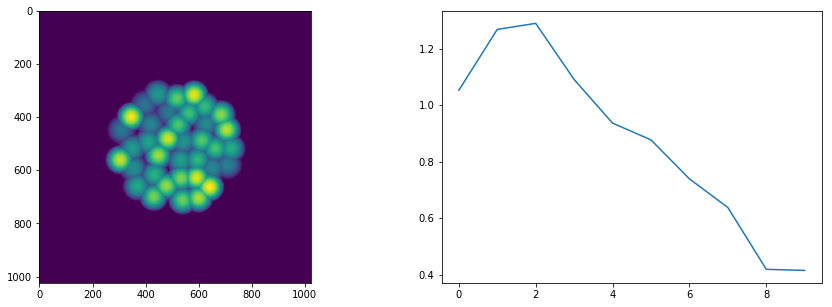

In [14]:
#model = msu_model(target_res=0.004,aberrations = True)  # zsampling options: 'fixed' or 'uniform_random'
load_init_from_file = False
# Load initialization from file
if load_init_from_file == True:
    print('loading initilization from file')
    file_best = '/media/hongdata/Kristina/MiniscopeData/best_init.mat'
    file_worst = '/media/hongdata/Kristina/MiniscopeData/worst_init.mat'
    model = load_model_from_file(model, file_best)
    
# Save initial values for later comparison 
Rmat=model(0)
R_init = Rmat
Tinit,aper,_= tf_utils.make_lenslet_tf_zern(model)

model_init = msu_model(target_res=0.004, aberrations = True, zernikes = zernikes_index)
#re_init_model(model_init,xinit,yinit,rinit,zerninit)

Rmat_init = model_init(0)

fig=plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(Tinit.numpy())
plt.subplot(1,2,2)
plt.plot(R_init.numpy())

In [ ]:
plt.figure()
print(tf.shape(aper))

#plt.plot(model.xg,tf.multiply(aper,Tinit).numpy()[400,:])
plt.imshow(aper.numpy()*Tinit.numpy())

In [ ]:
# psf_zstack =  model.gen_psf_stack(Tinit,.9,0)
# psf_zstack_lst = [np.array(psf_zstack[n].numpy()) for n in range(model.Nz)]
# psf_zstack_arr = np.array(psf_zstack_lst)
# save_dict = {
#     'zstack':psf_zstack_arr,
#     'xpos':model.xpos.numpy(),
#     'ypos':model.ypos.numpy(),
#     'r':model.rlist.numpy(),
#     'zerns':model.zernikes,
#     'zern_list':model.zernlist
# }
# sc.io.savemat("../psf_meas/zstack_sim_test.mat",save_dict)

In [ ]:
model.mean_lenslet_CA

In [ ]:
xp = xinit + tf.random_normal(tf.shape(xinit), stddev=.02)
yp = yinit + tf.random_normal(tf.shape(xinit), stddev=.02)
rp = rinit + tf.random_normal(tf.shape(xinit), stddev=.5)
rp = tf.minimum(rp,model.Rmax)
tp = tf.maximum(rp,model.Rmin)
re_init_model(model,xp,yp,rp,zerninit)
Rmat = model(0)
Tp,aper,_= tf_utils.make_lenslet_tf_zern(model)

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(Rmat.numpy())
ax[0].set_title('Rmat - random purturbation')

ax[1].imshow(Tinit.numpy()*aper.numpy())
ax[1].set_title('True surface')

ax[2].imshow(Tp.numpy()*aper.numpy())
ax[2].set_title('Initialization')

In [ ]:
def rot_xy(xloc,yloc,thetad):
    #rotmat = [np.cos(theta) -np.sin(theta); np.sin(theta) np.cos(theta)]
    
    xnew = np.cos(thetad*np.pi/180)*xloc - np.sin(thetad*np.pi/180)*yloc
    ynew = np.sin(thetad*np.pi/180)*xloc + np.cos(thetad*np.pi/180)*yloc
    return(xnew,ynew)

In [ ]:
xrot, yrot = rot_xy(xpos,-ypos,-210)
re_init_model(model, xrot,yrot,rlist,zerninit)



Trot,_,_ = tf_utils.make_lenslet_tf_zern(model)
psf_init_zstack = model.gen_psf_stack(Trot,aper,0)
def drawnow():
    display.display(plt.gcf())
    display.clear_output(wait=True)


f = plt.figure(figsize=(10,10))
for n in [2]:
    plt.imshow(psf_init_zstack[n])
    drawnow()

In [ ]:
psf_zstack =  model.gen_psf_stack(Tp,aper,0)

dp = 1
f, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(model.target_psf[dp])
ax[1].imshow(psf_zstack[dp])
ax[2].imshow(model.target_psf[dp] - psf_zstack[dp],vmax=.001)



In [ ]:
# psf_zstack =  model.gen_psf_stack(Tinit,.9,0)
# psf_zstack_lst = [np.array(psf_zstack[n].numpy()) for n in range(model.Nz)]
# psf_zstack_arr = np.array(psf_zstack_lst)
# sc.io.savemat("../psf_meas/zstack_sim_test.mat",{'zstack':psf_zstack_arr})

In [ ]:
def gradient (model, myloss, inputs):
    with tf.GradientTape() as tape:
        lossvalue, Rmat = myloss(model, inputs)
        return tape.gradient(lossvalue, model.variables),lossvalue, Rmat
    
def gradients_and_scaling(model, loss, inputs):
    grad,lossvalue, Rmat=gradient(model,loss, inputs)
    
    grad[0] = grad[0]
    #grad[1] = grad[1] * 1000
    #grad[2] = grad[2] * 1000
    
    grad[1] = grad[1]/5000.
    grad[2] = grad[2]/5000.


    grads=tf_utils.remove_nan_gradients(grad)
    return grads, lossvalue, Rmat


In [ ]:
re_init_model(model,xp,yp,rp,zerninit)

In [ ]:
# Options:
step_size = 10e-1   #1e-8 works well for l2
use_averaged_gradient = False  # True: uses averaged gradient, False: uses single gradient 
optimizer_type = 'nesterov'           # options: 'gd': normal gradient descent, 'nesterov': nesterov acceleration
num_iterations = 500
num_batches = 1
randomize_z = False   #If true, randomize zlist each epoch. If false, leave original order.
Rin = model(0)
nvars = len(model.variables)
#optimizer=tf.train.GradientDescentOptimizer(learning_rate=step_size)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=step_size)
#optimizer=tf.train.MomentumOptimizer(learning_rate=step_size,momentum= 0.9, use_nesterov = True)
fig, ax = plt.subplots(2,4,figsize=(15,5))

Tir = 0
Tic = 0
ax[Tir,Tic].imshow(Tinit)
ax[Tir,Tic].set_title('Initial surface')


Tor = 0
Toc = 1
ax[Tor,Toc].imshow(Tinit)
ax[Tor,Toc].set_title('Optimized surface')

Ter = 0
Tec = 2
imh = ax[Ter,Tec].imshow(Tinit - Tinit)
ax[Ter,Tec].set_title('Phase error')
cb = plt.colorbar(imh,ax=ax[Ter,Tec])

per = 0
pec = 3
pl = ax[per,pec].plot([])
ax[per,pec].set_title('phase MSE')

lr = 1
lc = 0
l = ax[lr,lc].semilogy([])
ax[lr,lc].set_title('Loss')

xyr = 1
xyc = 1
lh = ax[xyr,xyc].scatter(model.xpos.numpy(),model.ypos.numpy(),c='k', marker='.',label='init')
lh = ax[xyr,xyc].scatter(model.xpos.numpy(),model.ypos.numpy(),c='b', marker='.',label='opt')
ax[xyr,xyc].scatter(xinit,yinit,c='r',marker='x',label='target')
ax[xyr,xyc].axis('equal')

rr = 1
rc = 2
ax[rr,rc].plot(model.rlist.numpy(),'k.',label='init')
rh = ax[rr,rc].plot(model.rlist.numpy(),'b.',label='opt')
ax[rr,rc].plot(rinit,'rx',label='target')


Rr = 1
Rc = 3
Rh = ax[Rr,Rc].plot(Rin.numpy())


losslist = []
phase_err = []
rmean=[]

defocus_grid=  1./(np.linspace(1/model.zmin_virtual, 1./model.zmax_virtual, model.Nz * num_batches)) #mm or dioptres
    

if optimizer_type == 'nesterov':
    tk = tf.constant(1,tf.float32)
    tkp = tf.constant(1,tf.float32)

    #xkp = model.variables
    nvars = np.shape(model.variables)[0]
    xk = []
    xkp = []
    [xk.append(tf.Variable(tf.zeros(model.Nlenslets))) for n in range(nvars)]
    [xkp.append(tf.Variable(tf.zeros(model.Nlenslets))) for n in range(nvars)]
    [tf.assign(xkp[n],model.variables[n]) for n in range(nvars)]


for i in range(num_iterations):
    if randomize_z:
        defocus_epoch = np.random.permutation(defocus_grid)
    else:
        defocus_epoch = defocus_grid
    for j in range(num_batches):
        if use_averaged_gradient == True:
            grad,lossvalue, Rmat =  averaged_gradient(model, tf_utils.loss, num_averages = 10)
        else: 
            grad, lossvalue, Rmat = gradients_and_scaling(model, tf_utils.loss, defocus_epoch[j*model.Nz:j*model.Nz+model.Nz])  # initial value 


        #grad,lossvalue, Rmat=gradient(model,loss)

       # new_xpos = model.xpos - step_size*grad[2]
       # new_ypos = model.xpos - step_size*grad[3] 
        #new_grad, test_dist, test_dist_bool = constrain_distances(model, new_xpos, new_ypos, grad) # apply constraint 


        # Gradient step
        if optimizer_type == 'gd':
            optimizer.apply_gradients(zip(grad,model.variables),global_step=tf.train.get_or_create_global_step())
            # Projection step
            tf_utils.project_to_aper_keras(model)

        if optimizer_type == 'nesterov':

            optimizer.apply_gradients(zip(grad,model.variables),global_step=tf.train.get_or_create_global_step())


            # Projection step
            tf_utils.project_to_aper_keras(model)

            # Update variables for next loop
            tk = tkp
            [tf.assign(xk[n],xkp[n]) for n in range(nvars)]

            # Get state after project (gradient_step(yk))
            [tf.assign(xkp[n],model.variables[n]) for n in range(nvars)]

            #Acceleration
            tkp = 0.5*(1.0 + tf.sqrt(1.0 + 4*tf.square(tk)))

            bkp = (tk - 1)/tkp
            ykp = [xkp[n] + bkp*(xkp[n] - xk[n]) for n in range(nvars)]


            # Update model variables (yk)
            [model.variables[n].assign(ykp[n]) for n in range(nvars)]




        T,aper,T2=tf_utils.make_lenslet_tf_zern(model)

        losslist.append(lossvalue)
        phase_err.append(.5*tf.norm(T - Tinit)**2/model.samples[0]/model.samples[1])

        

        ax[Tor,Toc].imshow(T)

        l[0].remove()
        l = ax[lr,lc].semilogy(losslist,'k')
        ax[lr,lc].set_title('Loss')
        
        pl[0].remove()
        pl = ax[per,pec].plot(phase_err,'k')
        ax[per,pec].set_title('phase MSE')
        
        cb.remove()
        imh.remove()
        
        imh = ax[Ter,Tec].imshow(1000*(T - Tinit))
        ax[Ter,Tec].set_title('Phase error micron')
        cb = plt.colorbar(imh,ax=ax[Ter,Tec])
        
        lh.remove()
        lh = ax[xyr,xyc].scatter(model.xpos.numpy(),model.ypos.numpy(),c='b', marker='.',label='opt')
        ax[xyr,xyc].legend()
        ax[xyr,xyc].set_title('Positions')
        
        Rh[0].remove()
        Rh = ax[Rr,Rc].semilogy(Rmat.numpy(),'k')
        ax[Rr,Rc].set_title('Rmat')
        
        rh[0].remove()
        rh = ax[rr,rc].plot(model.rlist.numpy(),'b.',label='opt')
        ax[rr,rc].legend()
        display.display(plt.gcf())
        display.clear_output(wait=True)
#     pl.remove?
    


#cbar = fig.colorbar(rshow)

In [ ]:
lh = ax[xyr,xyc].scatter(model.xpos.numpy(),model.ypos.numpy(),c='b', marker='x')

print(nvars)
imh.remove()

In [ ]:
n = 5
sphere = tf.real(tf.sqrt(
    tf.square(model.rlist[n])
    - tf.square((model.xgm-model.xpos[n]))
    - tf.square((model.ygm-model.ypos[n]))))

piston = tf.real
(
    tf.sqrt
    (
        tf.square(model.rlist[n])-tf.square(model.mean_lenslet_CA)
    )
)

In [ ]:
max(model.rlist.numpy())

In [ ]:
print(model.rlist)

In [ ]:
Tgd,_,_= tf_utils.make_lenslet_tf_zern(model)
psf_zstack =  model.gen_psf_stack(Tgd,.9,.5)
vup =.05
#zdisp = 0
f, ax = plt.subplots(2,2,figsize=(12,12))
for zdisp in range(1):
    ax[0,0].imshow(model.target_psf[zdisp],vmax = vup)
    ax[0,0].set_title('target')
    ax[0,1].imshow(psf_zstack[zdisp],vmax=vup)
    ax[0,1].set_title('Optimized')
    ax[1,0].imshow(Tinit)
    ax[1,0].set_title('target')
    
    if zdisp != 0:
        cb.remove()
        e.remove()

    e = ax[1,1].imshow(model.target_psf[zdisp] - psf_zstack[zdisp])
   
    ax[1,1].set_title('error')
    cb = plt.colorbar(e,ax=ax[1,1])
    
    
    display.display(f)
    display.clear_output(wait=True)


In [ ]:
plt.plot(rinit.numpy(),label='init')
plt.plot(model.rlist.numpy(),label='opt')
plt.legend()
model_init.ypos.numpy() - model.ypos.numpy()